# Using XGBoost to predict Day Ahead prices (and comparisons with Linear Regression and Baseline)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [2]:
df_train = pd.read_csv("../ordered_train_set.csv", index_col=0)
df_validation = pd.read_csv("../ordered_seasonal_validation_set.csv", index_col=0)
df_test = pd.read_csv("../ordered_test_set.csv", index_col=0)

## Features 

The goal is to figure out what features (i.e., X) we can use to predict the Day Ahead price (DA_price) for a given hour (i.e., y). The following set of features are chosen based on experimentation and correlation analyses. 

In [3]:
features = ['actual_load', 'hour',
       'month', 'day_of_week', 'holiday', 'business_hour', 'season', 'temp',
       'dwpt', 'avg_DA_price(h-24)', 'avg_load(h-24)',
       'RT_price(t-1D)', 'DA_price(t-1D)', 'load(t-1D)', 'RT_price(t-2D)',
       'DA_price(t-2D)', 'load(t-2D)', 'RT_price(t-3D)', 'DA_price(t-3D)',
       'load(t-3D)', 'RT_price(t-4D)', 'DA_price(t-4D)', 'load(t-4D)',
       'RT_price(t-5D)', 'DA_price(t-5D)', 'load(t-5D)', 'RT_price(t-6D)',
       'DA_price(t-6D)', 'load(t-6D)', 'RT_price(t-7D)', 'DA_price(t-7D)',
       'load(t-7D)', 'nat_gas_spot_price', 'monthly_avg_NY_natgas_price']

In [4]:
X_train = df_train[features]
y_train = df_train['DA_price']

In [5]:
X_validation = df_validation[features]
y_validation = df_validation['DA_price']

In [6]:
X_test = df_test[features]
y_test = df_test['DA_price']

## XGBoost predictions on validation and test sets

In [7]:
model = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       objective='reg:linear',
                       early_stopping_rounds=100,
                       max_depth=3,
                       learning_rate=0.01)

In [8]:
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_validation, y_validation)],
              verbose=100)

[23:51:08] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:56.58786	validation_1-rmse:45.58367
[100]	validation_0-rmse:26.28004	validation_1-rmse:23.01760
[200]	validation_0-rmse:17.08766	validation_1-rmse:18.38465
[300]	validation_0-rmse:14.48207	validation_1-rmse:17.63989
[400]	validation_0-rmse:13.53040	validation_1-rmse:17.61368
[461]	validation_0-rmse:13.18789	validation_1-rmse:17.65416


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

#### Feature importance for the XGBoost model

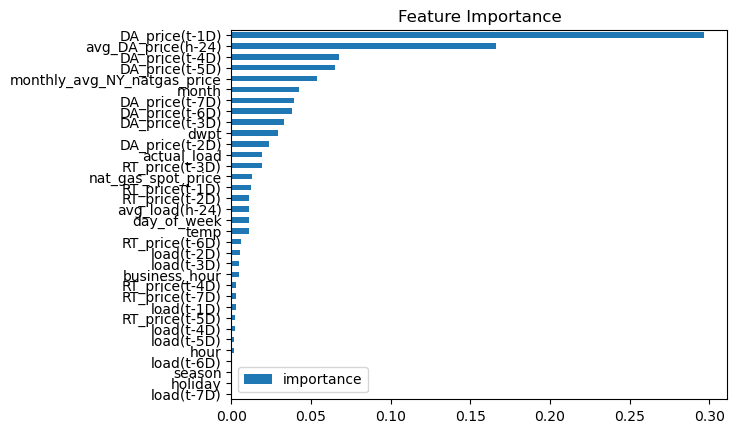

In [9]:
fi = pd.DataFrame(data=model.feature_importances_,
                            index=model.feature_names_in_,
                            columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [10]:
train_pred = model.predict(X_train)
# Evaluating the XGBoost model on train data
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
print(f"XGBoost RMSE on training: {train_rmse}")

val_pred = model.predict(X_validation)
# Evaluating the XGBoost model on validation data
val_rmse = np.sqrt(mean_squared_error(y_validation, val_pred))
print(f"XGBoost RMSE on validation: {val_rmse}")

test_pred = model.predict(X_test)
# Evaluating the XGBoost model on test data
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print(f"XGBoost RMSE on test: {test_rmse}")

XGBoost RMSE on training: 13.825522686789641
XGBoost RMSE on validation: 17.55101439149192
XGBoost RMSE on test: 21.505649600698767


## Linear Regression predictions on validation and test sets

In [11]:
linear_reg = LinearRegression(copy_X=True)
linear_reg.fit(X_train, y_train)

LinearRegression()

In [12]:
lin_reg_val_pred = linear_reg.predict(X_validation)
# Evaluating the Linear Regression model on validation data
lin_reg_val_rmse = np.sqrt(mean_squared_error(y_validation, lin_reg_val_pred))
print(f"Linear regression RMSE on validation: {lin_reg_val_rmse}")

lin_reg_test_pred = linear_reg.predict(X_test)
# Evaluating the Linear Regression model on test data
lin_reg_test_rmse = np.sqrt(mean_squared_error(y_test, lin_reg_test_pred))
print(f"Linear regression RMSE on test: {lin_reg_test_rmse}")

Linear regression RMSE on validation: 21.84022728496911
Linear regression RMSE on test: 19.38810297839113


## Baseline predictions on validation and test sets

In [13]:
# Evaluating the Baseline model on validation data
base_line_val_rmse = np.sqrt(mean_squared_error(df_validation['DA_price'], df_validation['DA_price(t-1D)']))

#Evaluating the Baseline model on test data
base_line_test_rmse = np.sqrt(mean_squared_error(df_test['DA_price'], df_test['DA_price(t-1D)']))

In [14]:
print(f"Baseline RMSE on validation = {base_line_val_rmse}")
print(f"Baseline RMSE on test = {base_line_test_rmse}")

Baseline RMSE on validation = 25.956556020205632
Baseline RMSE on test = 20.50418041624876


## Dataframes with all the predictions

In [15]:
df_validation_preds = df_validation[['time','DA_price', 'DA_price(t-1D)']]
df_validation_preds.reset_index(drop=True, inplace=True)
df_validation_preds = df_validation_preds.rename(columns = { 'DA_price(t-1D)' : 'Baseline_predictions' })

df_validation_preds['XGBoost_predictions'] = val_pred
df_validation_preds['Linear_Regression_predictions'] = lin_reg_val_pred

# Reorder columns
df_validation_preds = df_validation_preds[['time', 'DA_price', 'XGBoost_predictions', 
                                          'Linear_Regression_predictions', 'Baseline_predictions' ]]

In [16]:
df_validation_preds.head()

,time,DA_price,XGBoost_predictions,Linear_Regression_predictions,Baseline_predictions
0,2022-09-01 00:00:00,69.16,89.743683,92.625353,101.36
1,2022-09-01 01:00:00,64.95,78.503838,81.492136,85.61
2,2022-09-01 02:00:00,64.25,75.630875,76.904460,80.40
3,2022-09-01 03:00:00,63.12,73.767258,73.649078,77.43
4,2022-09-01 04:00:00,63.82,73.767258,72.543781,77.49


In [17]:
df_test_preds = df_test[['time','DA_price', 'DA_price(t-1D)']]
df_test_preds.reset_index(drop=True, inplace=True)
df_test_preds = df_test_preds.rename(columns = { 'DA_price(t-1D)' : 'Baseline_predictions' })

df_test_preds['XGBoost_predictions'] = test_pred
df_test_preds['Linear_Regression_predictions'] = lin_reg_test_pred

# Reorder columns
df_test_preds = df_test_preds[['time', 'DA_price', 'XGBoost_predictions', 
                                          'Linear_Regression_predictions', 'Baseline_predictions' ]]

In [18]:
df_test_preds.head()

,time,DA_price,XGBoost_predictions,Linear_Regression_predictions,Baseline_predictions
0,2022-08-30 00:00:00,107.90,95.507324,107.903859,96.51
1,2022-08-30 01:00:00,90.86,89.891068,97.170069,85.91
2,2022-08-30 02:00:00,84.54,81.745865,92.725925,82.93
3,2022-08-30 03:00:00,84.80,80.550568,87.780497,79.22
4,2022-08-30 04:00:00,88.75,79.074242,86.567311,79.63
